### [모듈 불러오기]

In [38]:
import dill
import time
import random
import numpy as np
from sklearn.metrics import roc_curve, auc

import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn

from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import BucketIterator
from torchtext.data import Iterator


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\choic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
RANDOM_SEED = 2020
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DATA_PATH = "data/processed/"

In [2]:
print(torch.__version__)

1.7.1+cpu


### [모델 클래스 정의하기]

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(
        self, num_embeddings, embedding_dim, hidden_size, num_layers, pad_idx
    ):
        super().__init__()
        self.embed_layer = nn.Embedding(
        # 생성할 Embedding Layer의 크기를 정해줌, 보통은 단어장의 크기
        num_embeddings=num_embeddings,
        embedding_dim=embedding_dim,
        # 자연어 처리에서 배치별로 문장의 크기를 맞추기 위해서 짧은 문장에 Padding을 붙여서 길이를 맞춤
        # 그런데 이 Padding은 특별한 의미를 갖고 있지 않음
        # 학습에서 제외하기 위해 Padding이 단어장에서 어떤 숫자를 갖고 있는지 알려줌으로써 학습되지 않게 함.
        padding_idx=pad_idx
        )
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5
        )
        self.last_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            # 마지막 Output 크기를 1로 줌 (맞는지 아닌지 점수가 가장 낮은 문장이 문법적으로 맞지 않다고 판단)
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

### [모델 파이프라인 정의]

In [4]:
def forward(self, x):
    # 이 모델은 숫자로 이루어진 토큰을 Input으로 받는다고 가정
    # 그렇기에 우선 들어온 Input 값을 Embedding 값으로 변환시켜 주어야 함
    embed_x = self.embed_layer(x)
    # LSTM은 Output, (Hidden State, Cell State)를 반환 함, 이 중 State 값들은 사용하지 않으므로 반환 받지 않음
    output, (_, _) = self.lstm_layer(embed_x)
    # LSTM의 Output은 (배치 크기, 문장 길이, Output Size)라는 Size를 갖고 있음. 가장 마지막 단어의 결과 값만 사용
    last_output = output[:, -1, :]
    # 문장의 마지막 단어의 Output을 Fully Connected Layer에 통과시켜 확률값을 계산
    last_ouput = self.last_layer(last_output)
    return last_output

## >데이터셋 불러오기<

**파일에서 필요한 Field 선언하기**  
1 TEXT = Field(...)  
2 LABEL = Field(...)  
**데이터 불러오기**  
3 dataset = TabularDataset  
**불러온 데이터로 단어장 만들기**  
4 TEXT.build_vocab(dataset)  
**Data Loader 만들기**  
5 data_loadet = BucketIterator(dataset, ..)

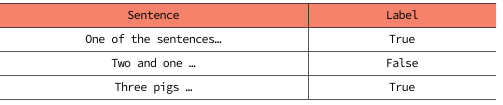  
문장은 TEXT, 정답은 LABEL로 각각의 Field를 정의

### [문장 필드 정의]

In [5]:
TEXT = Field(
    sequential=True, # 1
    use_vocab=True, # 2
    tokenize=word_tokenize, # 3
    lower=True, # 4
    batch_first=True # 5
)

C:\Users\choic\anaconda3\envs\book\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


1. TEXT는 문장이 들어오는 Field. Sequential=True로 설정해서 이 필드에는 문장이 들어온다는 것을 알려줌
2. 단어를 숫자로 변환시켜주는 단어장을 만들기 위해 이 필드를 이용함
3. 불러온 문장을 토크나이징 할 함수를 입력. nltk의 word_tokenize를 이용 할 것임. word_tokenize는 영어로 이루어진 문장을 토큰화시킬 때 가장 기본적으로 사용됨.
4. 대소문자를 구분할지 말지를 설정하는 부분. 따로 대명사를 처리하지 않을 것이기에 모두 소문자로 처리
5. 자연어를 처리하는 모듈별로 지원하는 데이터의 형태가 다름. 크게 다음 두가지 형태가 있음.
- (배치, 문장)
- (문장, 배치)  
이 중 첫 번째의 방식이 필요하기에 True를 줌

### [정답 필드 정의]

In [6]:
LABEL = Field(
    sequential=False, # 1
    use_vocab=False, # 2
    batch_first=True,
)

1. 앞에서는 문장이 들어오기 때문에 True를 주었지만 이 열은 정답이 있는 열이기에 False를 줌
2. 또한 이 Field에서는 따로 단어장을 생성하지 않기에 False를 줌

### [데이터 불러오기]

In [7]:
sat_train_data, sat_valid_data, sat_test_data = \
    TabularDataset.splits(
    path='data/processed', # 1
    train='sat_train.tsv', # 2
    validation='sat_valid.tsv',
    test = 'sat_test.tsv',
    format = 'tsv', # 3
    fields = [('text', TEXT), ('label', LABEL)], # 4
    skip_header = 1, # 5
)
TEXT.build_vocab(sat_train_data, min_freq=2) # 6

C:\Users\choic\anaconda3\envs\book\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
C:\Users\choic\anaconda3\envs\book\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


1. 데이터가 들어 있는 폴더의 경로를 입력
2. 각각 Train, Validation, Test의 파일명을 입력
3. 데이터의 파일 포맷 형태를 줍니다. 사용할 데이터는 Tap separated value의 데이터이기에 tsv를 입력
4. 앞에서 정의한 Field를 입력해주는 부분. 입력할 때 실제 데이터의 컬럼 순서로 입력해주어야함. 그리고 Field의 이름과 Field를 묶음. 예를 들어 ("text", TEXT)라면 이 데이터는 첫 번째 컬럼에 문장이 있고 그 컬럼명을 text로 하겠다는 뜻
5. 데이터의 첫 번째 열에는 원래의 컬럼명이 들어 있음. 데이터로 사용되지 않기 때문에 따로 불러오지 않도록 해야함. 그렇기에 1을 주어서 첫 번째 열을 생략하도록 함.
6. 마지막으로 불러온 데이터 중 훈련 데이터를 이용해 TEXT의 단어장을 생성함

불러온 데이터로 Data Loader를 만들어야 하는데 일반적인 Data Loader은  
랜덤하게 추출 -> 각 문장을 정해진 길이에 맞추기 -> Tensor로 변환  

정해진 길이에 맞추기 : torchtext.BucketIterator 이용

### [Data Loader 정의]

In [25]:
sat_train_iterator, sat_valid_iterator, sat_test_iterator = BucketIterator.splits(
    (sat_train_data, sat_valid_data, sat_test_data),
    batch_size=8,
    device=None,
    sort=False,
)


C:\Users\choic\anaconda3\envs\book\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


1. 앞에서 불러온 데이터들을 묶어서 입력해줌
2. Data Loader에서 각 배치별 크기를 의미

## >학습<  
  
1. Data Loader에서 배치 불러오기
2. 배치를 모델에 넣어서 데이터 형태 맞추기
3. 배치를 모델에 넣어서 예측값 얻기
4. 정답과 예측값을 비교해서 Loss 계산하기
5. Loss를 이용해 모델 학습시키기

### [모델 학습 함수 정의]

In [29]:
def train(model: nn.Module, iterator: Iterator, optimizer: torch.optim.Optimizer, criterion: nn.Module, device: str):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator): # 1
        optimizer.zero_grad()
        text = batch.text # 2
        if text.shape[0] > 1:
            label = batch.label.type(torch.FloatTensor) # 3
            text = text.to(device)
            label = label.to(device)
            output = model(text).flatten() # 4
            loss = criterion(output, label) # 5
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

1. 입력 받은 Data Loader를 호출해 Batch를 부르는 코드
2. Batch는 두 개의 Attribute를 갖고 있음. 앞서 데이터를 불러올 때 준 fields=[("text", TEXT), ("label", LABEL)]에서 앞의 단어들. 여기서 text는 batch의 문장, label은 Batch의 정답을 갖고 있음
3. 문장과 정답을 불러와서 필요한 데이터 형태로 변환
4. 모델에 문장을 넣어서 결과를 출력
5. 출력된 겨로가와 정답을 비교해서 Loss를 구함

### [모델 평가 함수 정의]

In [31]:
def evaluate(model: nn.Module, iterator: Iterator, criterion: nn.Module, device: str):
    model.eval() # 1
    epoch_loss = 0

    with torch.no_grad(): # 2
        for _, batch in enumerate(iterator):
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            text = text.to(device)
            label = label.to(device)
            output = model(text).flatten()
            loss = criterion(output, label)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

1. Dropout과 같이 훈련과 평가의 동작이 다른 모듈들은 각 목적에 맞게 변화를 주어야 함. 여기서는 평가를 하기 위해 model.eval()를 먼저 선언
2. torch에서는 기본적으로 Forward를 할 때 자동으로 Gradient를 계산. 하지만 평가를 진행할 때는 Gradient를 계산할 필요가 없음.

In [32]:

def test(model: nn.Module, iterator: Iterator, device: str):
    model.eval()
    with torch.no_grad():
        y_real = []
        y_pred = []
        for batch in iterator:
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            text = text.to(device)
            output = model(text).flatten().cpu()
            y_real += [label]
            y_pred += [output]
        y_real = torch.cat(y_real)
        y_pred = torch.cat(y_pred)

    fpr, tpr, _ = roc_curve(y_real, y_pred)
    auroc = auc(fpr, tpr)

    return auroc


def epoch_time(start_time: int, end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### [HyperParameter 선언]

In [21]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 20

lstm_classifier = LSTMClassifier(
    num_embeddings=len(TEXT.vocab),
    embedding_dim=100,
    hidden_size=200,
    num_layers=4,
    pad_idx=PAD_IDX,
)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
_ = lstm_classifier.to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters())
bce_loss_fn = nn.BCELoss()

### [모델 학습]

In [37]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(lstm_classifier, sat_train_iterator, optimizer, bce_loss_fn, device)
    valid_loss = evaluate(lstm_classifier, sat_valid_iterator, bce_loss_fn, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")

NotImplementedError: 